## 1. Rationale

* due to the sparseness, the ps is binned to 20 (can change) 
* then chisq test wheter the ratio of openning is dependent on bins 

##  2. load data

In [1]:
require(data.table)
dat.pro_ps<- fread("../dat/1901/alpha_beta.promoter.long_matrix_w_transcripts_ps.txt")

Loading required package: data.table


In [2]:
head(dat.pro_ps)
dim(dat.pro_ps)

gene_tr.idx,cluster,cell,ps
SAMD11_7,alpha_1,Islet1-fresh_AGACACCTAGGCAGAAGTAAGGAGCAGGA,5.643735
SAMD11_7,alpha_1,Islet1-fresh_AGACACCTATGCGCAGCGTCTAATGGTTG,1.056578
SAMD11_7,alpha_2,Islet1-fresh_AGACACCTCGAGGCTGAAGGCTATGGTTG,6.254863
SAMD11_7,alpha_2,Islet1-fresh_AGACACCTCGTACTAGCTAAGCCTGTACT,6.508574
SAMD11_7,alpha_1,Islet1-fresh_AGACACCTGGACTCCTTCGACTAGGGTTG,2.120670
SAMD11_7,alpha_2,Islet1-fresh_AGACACCTGGAGCTACAAGGAGTAAGGCG,5.564368


[1] 19412387        4

### 2.1 bin data 

In [4]:
require(tidyverse)
ps.range <- list()
ps.range$alpha <- range((dat.pro_ps %>%filter(cluster %in% c("alpha_1","alpha_2")))$ps)
ps.range$beta <- range((dat.pro_ps %>%filter(cluster %in% c("beta_1","beta_2")))$ps)
ps.range

$alpha
[1] 0.000000 6.746176

$beta
[1]  0.0000 20.2079

In [6]:
head(dat.pro_ps)

gene_tr.idx,celltype,subtype,cell,ps,ps_bin
SAMD11_7,alpha,1,Islet1-fresh_AGACACCTAGGCAGAAGTAAGGAGCAGGA,5.643735,"(5.4,6.07]"
SAMD11_7,alpha,1,Islet1-fresh_AGACACCTATGCGCAGCGTCTAATGGTTG,1.056578,"(0.675,1.35]"
SAMD11_7,alpha,2,Islet1-fresh_AGACACCTCGAGGCTGAAGGCTATGGTTG,6.254863,"(6.07,6.75]"
SAMD11_7,alpha,2,Islet1-fresh_AGACACCTCGTACTAGCTAAGCCTGTACT,6.508574,"(6.07,6.75]"
SAMD11_7,alpha,1,Islet1-fresh_AGACACCTGGACTCCTTCGACTAGGGTTG,2.120670,"(2.02,2.7]"
SAMD11_7,alpha,2,Islet1-fresh_AGACACCTGGAGCTACAAGGAGTAAGGCG,5.564368,"(5.4,6.07]"


In [7]:
N.bin<- 11
ps.bks <- list()
ps.bks$alpha <- seq(ps.range$alpha[1],ps.range$alpha[2],length.out = N.bin)
ps.bks$beta <- seq(ps.range$beta[1],ps.range$beta[2],length.out = N.bin)

dat.pro_ps <- rbind(
    dat.pro_ps%>% 
    filter(cluster %in% c("alpha_1","alpha_2"))%>%
    mutate(ps_bin =cut(ps,breaks = ps.bks$alpha,include.lowest = T)),
    dat.pro_ps%>% 
    filter(cluster %in% c("beta_1","beta_2"))%>%
    mutate(ps_bin =cut(ps,breaks = ps.bks$beta,include.lowest = T))
)%>%separate(cluster,into=c("celltype","subtype"))

ps.bin.dat.sum<- dat.pro_ps%>%
    select(-one_of("gene_tr.idx","ps"))%>%distinct()

setDT(ps.bin.dat.sum)
ps.bin.dat.sum<-ps.bin.dat.sum[, .(.N), by = .(ps_bin,celltype)]
cat(paste(N.bin,"# bins:\n"))
cat("quantiles of alpha cell number per bin:\n")
t(quantile((ps.bin.dat.sum%>%filter(celltype=="alpha"))$N))
cat("quantiles of beta cell number per bin:\n")
t(quantile((ps.bin.dat.sum%>%filter(celltype=="beta"))$N))

11 # bins:
quantiles of alpha cell number per bin:


0%,25%,50%,75%,100%
210,365.75,590,728.5,845


quantiles of beta cell number per bin:


0%,25%,50%,75%,100%
131,250.25,592.5,968.25,1904


In [8]:
ps.bin.dat.sum%>%group_by(celltype)%>%summarise(tot=sum(N))

celltype,tot
alpha,5594
beta,7170


In [9]:
#fwrite(dat.pro_ps,file = "../dat/1901/dat.pro_ps.csv")

## 3. run chisq test on dependence on bin

In [23]:
require(parallel)
ps.bin.dat.sum.2<-ps.bin.dat.sum%>%
    as.data.frame()%>%
    mutate(ps_bin =as.character(ps_bin))%>%
    column_to_rownames("ps_bin")

run_chisq_test<- function(g="SAMD11_7",dat){
    test.dat <- dat%>%
        mutate(ps_bin=droplevels(ps_bin))%>%
    filter(gene_tr.idx==g)%>%
    select(one_of("celltype","ps_bin"))

    test.dat.tab <- as.matrix(t(table(test.dat$ps_bin)))
    test.dat.tab<-rbind(test.dat.tab,ps.bin.dat.sum.2[colnames(test.dat.tab),'N']-test.dat.tab[1,])
    rownames(test.dat.tab)<- c("open","close")
    chisq <- chisq.test(test.dat.tab,simulate.p.value=F)
    chisq$p.value
}

system.time(res <- lapply(c("alpha","beta"),function(ct){
    dat.sub <- dat.pro_ps%>%filter(celltype ==ct)
    all_tr <- unique(dat.sub$gene_tr.idx)[1:20]
    tmp <- mclapply(all_tr,function(g){
        run_chisq_test(g,dat=dat.sub)
    },mc.cores = 6)
    names(tmp) <- all_tr
    tmp
}))
names(res) <- c("alpha","beta")
saveRDS(res,'../dat/1901/chisq_10bin_res.Rds')

### frac & smooth 

In [49]:
head(ps.bin.dat.sum)

ps_bin,celltype,N
"(5.4,6.07]",alpha,305
"(0.675,1.35]",alpha,845
"(6.07,6.75]",alpha,628
"(2.02,2.7]",alpha,548
"(2.7,3.37]",alpha,552
"(3.37,4.05]",alpha,748


Joining, by = c("celltype", "ps_bin")


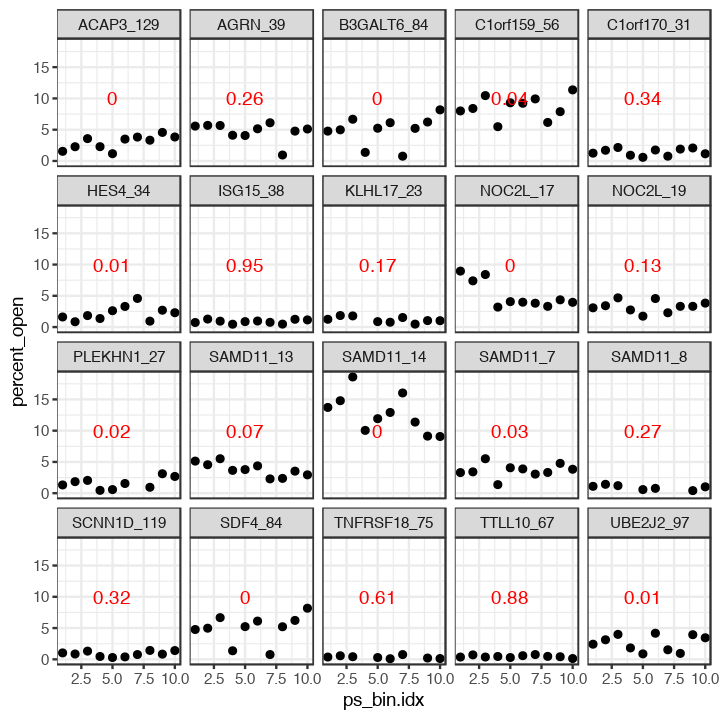

In [63]:
options(repr.plot.width=6, repr.plot.height=6)
dat.pro_ps.filtered <- dat.pro_ps%>%filter(celltype =="beta")
all_tr <- unique(dat.pro_ps.filtered$gene_tr.idx)
dat.pro_ps.long <- dat.pro_ps.filtered%>%
    filter(gene_tr.idx %in% all_tr[1:20])%>%
    group_by(gene_tr.idx,celltype,ps_bin)%>%
    summarise(n= n())%>%
    left_join(ps.bin.dat.sum)%>%arrange(gene_tr.idx,ps_bin)%>%
    droplevels()%>%     
    mutate(ps_bin.idx = as.numeric(ps_bin))%>% 
    mutate(percent_open=n/N*100)


require(ggplot2)
ggplot(dat.pro_ps.long,aes(x = ps_bin.idx,y=percent_open))+
    geom_point()+facet_wrap(~gene_tr.idx)+theme_bw()+
    geom_text(data = data.frame(pval=round(unlist(tmp$beta),2))%>%
    rownames_to_column("gene_tr.idx")%>%
    mutate(ps_bin.idx=5,percent_open=10),aes(label=pval),color='red')


In [54]:
droplevels(dat.pro_ps.long$ps_bin)

[1] [0,2.02]    (2.02,4.04] (4.04,6.06] (6.06,8.08] (8.08,10.1] (10.1,12.1]
  [7] (12.1,14.1] (14.1,16.2] (16.2,18.2] (18.2,20.2] [0,2.02]    (2.02,4.04]
 [13] (4.04,6.06] (6.06,8.08] (8.08,10.1] (10.1,12.1] (12.1,14.1] (14.1,16.2]
 [19] (16.2,18.2] (18.2,20.2] [0,2.02]    (2.02,4.04] (4.04,6.06] (6.06,8.08]
 [25] (8.08,10.1] (10.1,12.1] (12.1,14.1] (14.1,16.2] (16.2,18.2] (18.2,20.2]
 [31] [0,2.02]    (2.02,4.04] (4.04,6.06] (6.06,8.08] (8.08,10.1] (10.1,12.1]
 [37] (12.1,14.1] (14.1,16.2] (16.2,18.2] (18.2,20.2] [0,2.02]    (2.02,4.04]
 [43] (4.04,6.06] (6.06,8.08] (8.08,10.1] (10.1,12.1] (12.1,14.1] (14.1,16.2]
 [49] (16.2,18.2] (18.2,20.2] [0,2.02]    (2.02,4.04] (4.04,6.06] (6.06,8.08]
 [55] (8.08,10.1] (10.1,12.1] (12.1,14.1] (14.1,16.2] (16.2,18.2] (18.2,20.2]
 [61] [0,2.02]    (2.02,4.04] (4.04,6.06] (6.06,8.08] (8.08,10.1] (10.1,12.1]
 [67] (12.1,14.1] (14.1,16.2] (16.2,18.2] (18.2,20.2] [0,2.02]    (2.02,4.04]
 [73] (4.04,6.06] (8.08,10.1] (10.1,12.1] (12.1,14.1] (14.1,16.2] (16.2,18.2]
 [79] (18.2,20.2] [0,2.02]    (2.02,4.04] (4.04,6.06] (6.06,8.08] (8.08,10.1]
 [85] (10.1,12.1] (12.1,14.1] (14.1,16.2] (16.2,18.2] (18.2,20.2] [0,2.02]   
 [91] (2.02,4.04] (4.04,6.06] (6.06,8.08] (8.08,10.1] (10.1,12.1] (12.1,14.1]
 [97] (14.1,16.2] (16.2,18.2] (18.2,20.2] [0,2.02]    (2.02,4.04] (4.04,6.06]
[103] (6.06,8.08] (8.08,10.1] (10.1,12.1] (14.1,16.2] (16.2,18.2] (18.2,20.2]
[109] [0,2.02]    (2.02,4.04] (4.04,6.06] (6.06,8.08] (8.08,10.1] (10.1,12.1]
[115] (12.1,14.1] (14.1,16.2] (16.2,18.2] (18.2,20.2] [0,2.02]    (2.02,4.04]
[121] (4.04,6.06] (6.06,8.08] (8.08,10.1] (10.1,12.1] (12.1,14.1] (14.1,16.2]
[127] (16.2,18.2] (18.2,20.2] [0,2.02]    (2.02,4.04] (4.04,6.06] (6.06,8.08]
[133] (8.08,10.1] (10.1,12.1] (12.1,14.1] (14.1,16.2] (16.2,18.2] (18.2,20.2]
[139] [0,2.02]    (2.02,4.04] (4.04,6.06] (8.08,10.1] (10.1,12.1] (16.2,18.2]
[145] (18.2,20.2] [0,2.02]    (2.02,4.04] (4.04,6.06] (6.06,8.08] (8.08,10.1]
[151] (10.1,12.1] (12.1,14.1] (14.1,16.2] (16.2,18.2] (18.2,20.2] [0,2.02]   
[157] (2.02,4.04] (4.04,6.06] (6.06,8.08] (8.08,10.1] (10.1,12.1] (12.1,14.1]
[163] (14.1,16.2] (16.2,18.2] (18.2,20.2] [0,2.02]    (2.02,4.04] (4.04,6.06]
[169] (8.08,10.1] (10.1,12.1] (12.1,14.1] (16.2,18.2] (18.2,20.2] [0,2.02]   
[175] (2.02,4.04] (4.04,6.06] (6.06,8.08] (8.08,10.1] (10.1,12.1] (12.1,14.1]
[181] (14.1,16.2] (16.2,18.2] (18.2,20.2] [0,2.02]    (2.02,4.04] (4.04,6.06]
[187] (6.06,8.08] (8.08,10.1] (10.1,12.1] (12.1,14.1] (14.1,16.2] (16.2,18.2]
[193] (18.2,20.2]
10 Levels: [0,2.02] (2.02,4.04] (4.04,6.06] (6.06,8.08] ... (18.2,20.2]

gene_tr.idx,pval,ps_bin.idx,percent_open
SAMD11_7,0.03,5,10
SAMD11_8,0.27,5,10
SAMD11_13,0.07,5,10
SAMD11_14,0.00,5,10
NOC2L_17,0.00,5,10
NOC2L_19,0.13,5,10
KLHL17_23,0.17,5,10
PLEKHN1_27,0.02,5,10
C1orf170_31,0.34,5,10
HES4_34,0.01,5,10
